In [1]:
import cv2
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from math import ceil

ml_colors = ['red','yellow','lime','aqua','magenta','navy','hotpink']*100

In [31]:
def plot_images(images: list, contours_list: np.array = None, n=16):
    
    images = images[:n]
    
    n_images = len(images)
    n_columns = 4
    n_rows = ceil(n_images/n_columns)

    x_size = 12
    y_size = int( n_rows*x_size/n_columns )

    fig, axes = plt.subplots(n_rows, n_columns, figsize=(x_size, y_size), sharex=True, sharey=True)

    plt.subplots_adjust(left=0.0,
                        bottom=0.0,
                        right=1,
                        top=1,
                        wspace=0.05,
                        hspace=0.05)
    
    ax = axes.flatten()

    for axs in ax[n_images:]:
        axs.remove()

    for i, img in enumerate(images):
        ax[i].set_axis_off()

        image = img.copy()
        image = image.astype('uint8')
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        if contours_list is not None:

            img_contours = contours_list[i]
            cv2.drawContours(image, img_contours, -1, (0, 255, 0), 2)  # -1 means draw all contours, (0, 255, 0) is the color, 2 is the thickness
        
        ax[i].imshow(image)
     
    plt.show()

## Carregando e visualizando as imagens

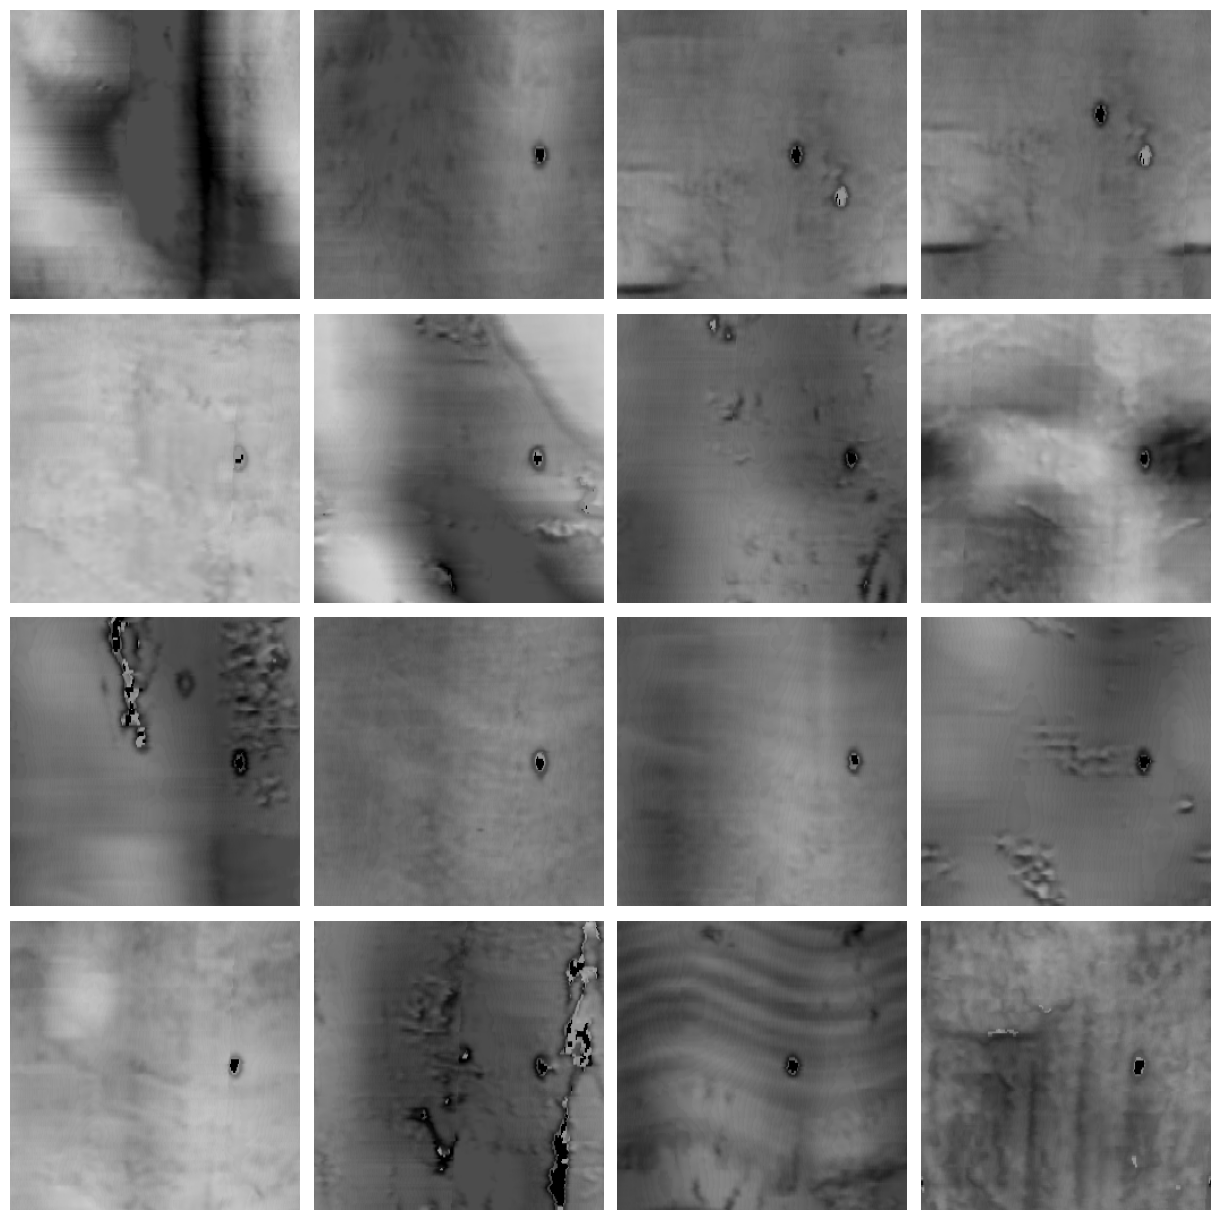

In [3]:
imgs_dir = '../data/train/image/*'
imgs_paths = glob(imgs_dir)
imgs_paths = sorted(imgs_paths)


# Create list with all images in gray scale
images_gray = [ cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) for image_path in imgs_paths]
images_gray = images_gray[:42]
# Visualizando imagens
plot_images(images_gray)

In [4]:
from skimage import feature

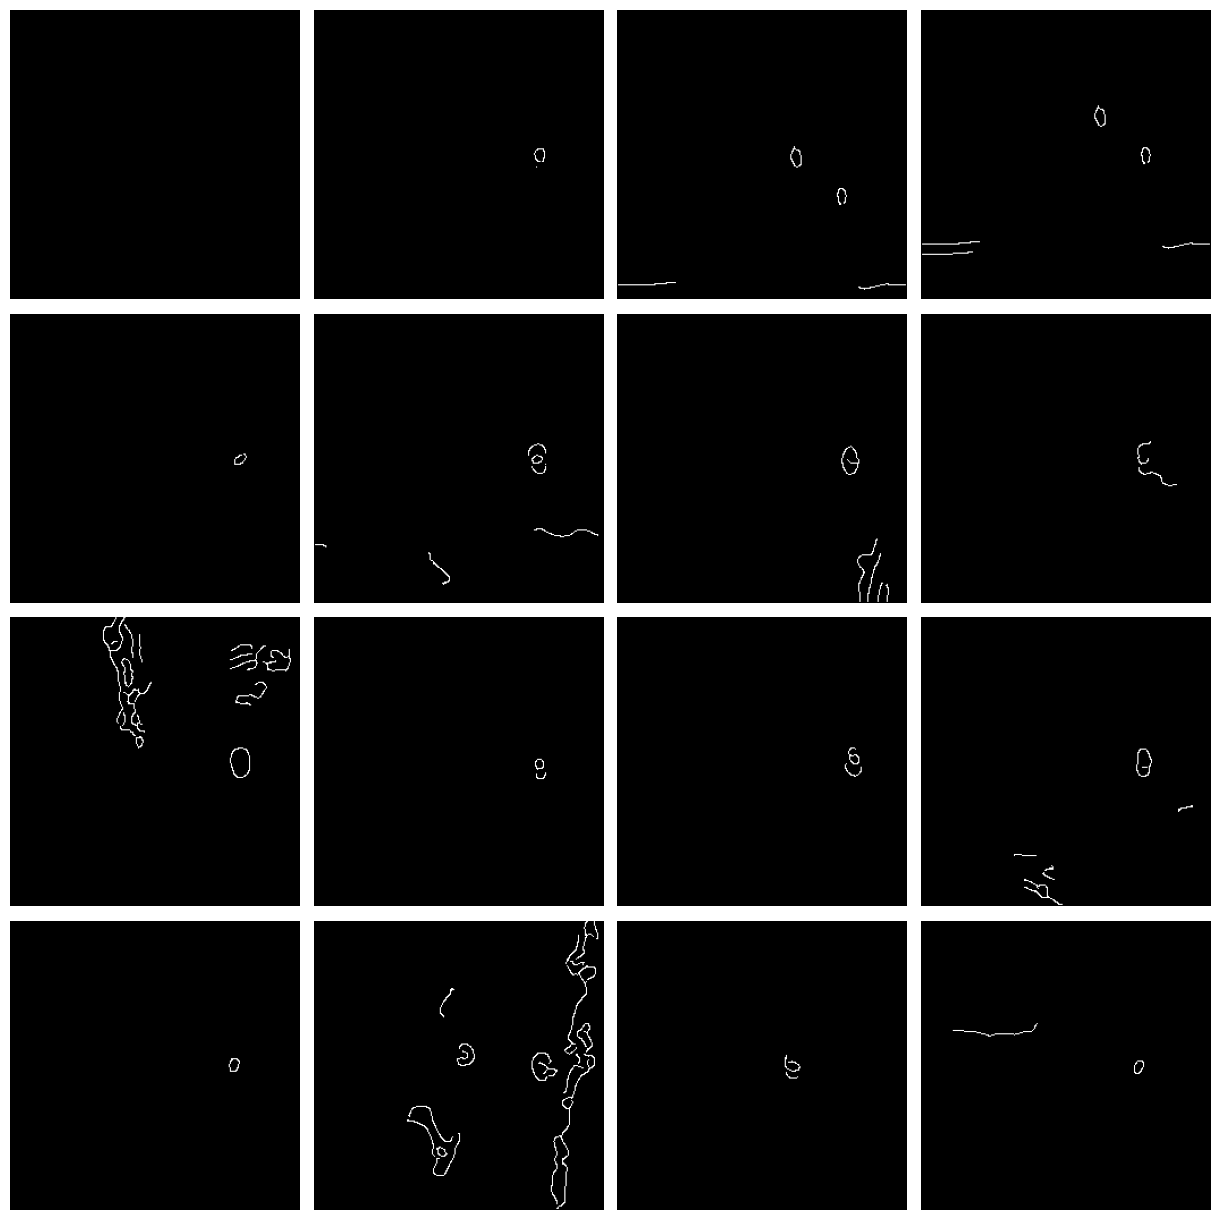

In [51]:
images_canny = [ 
             feature.canny(img, sigma=2.7)*255.0
             for img in images_gray]


plot_images(images_canny)

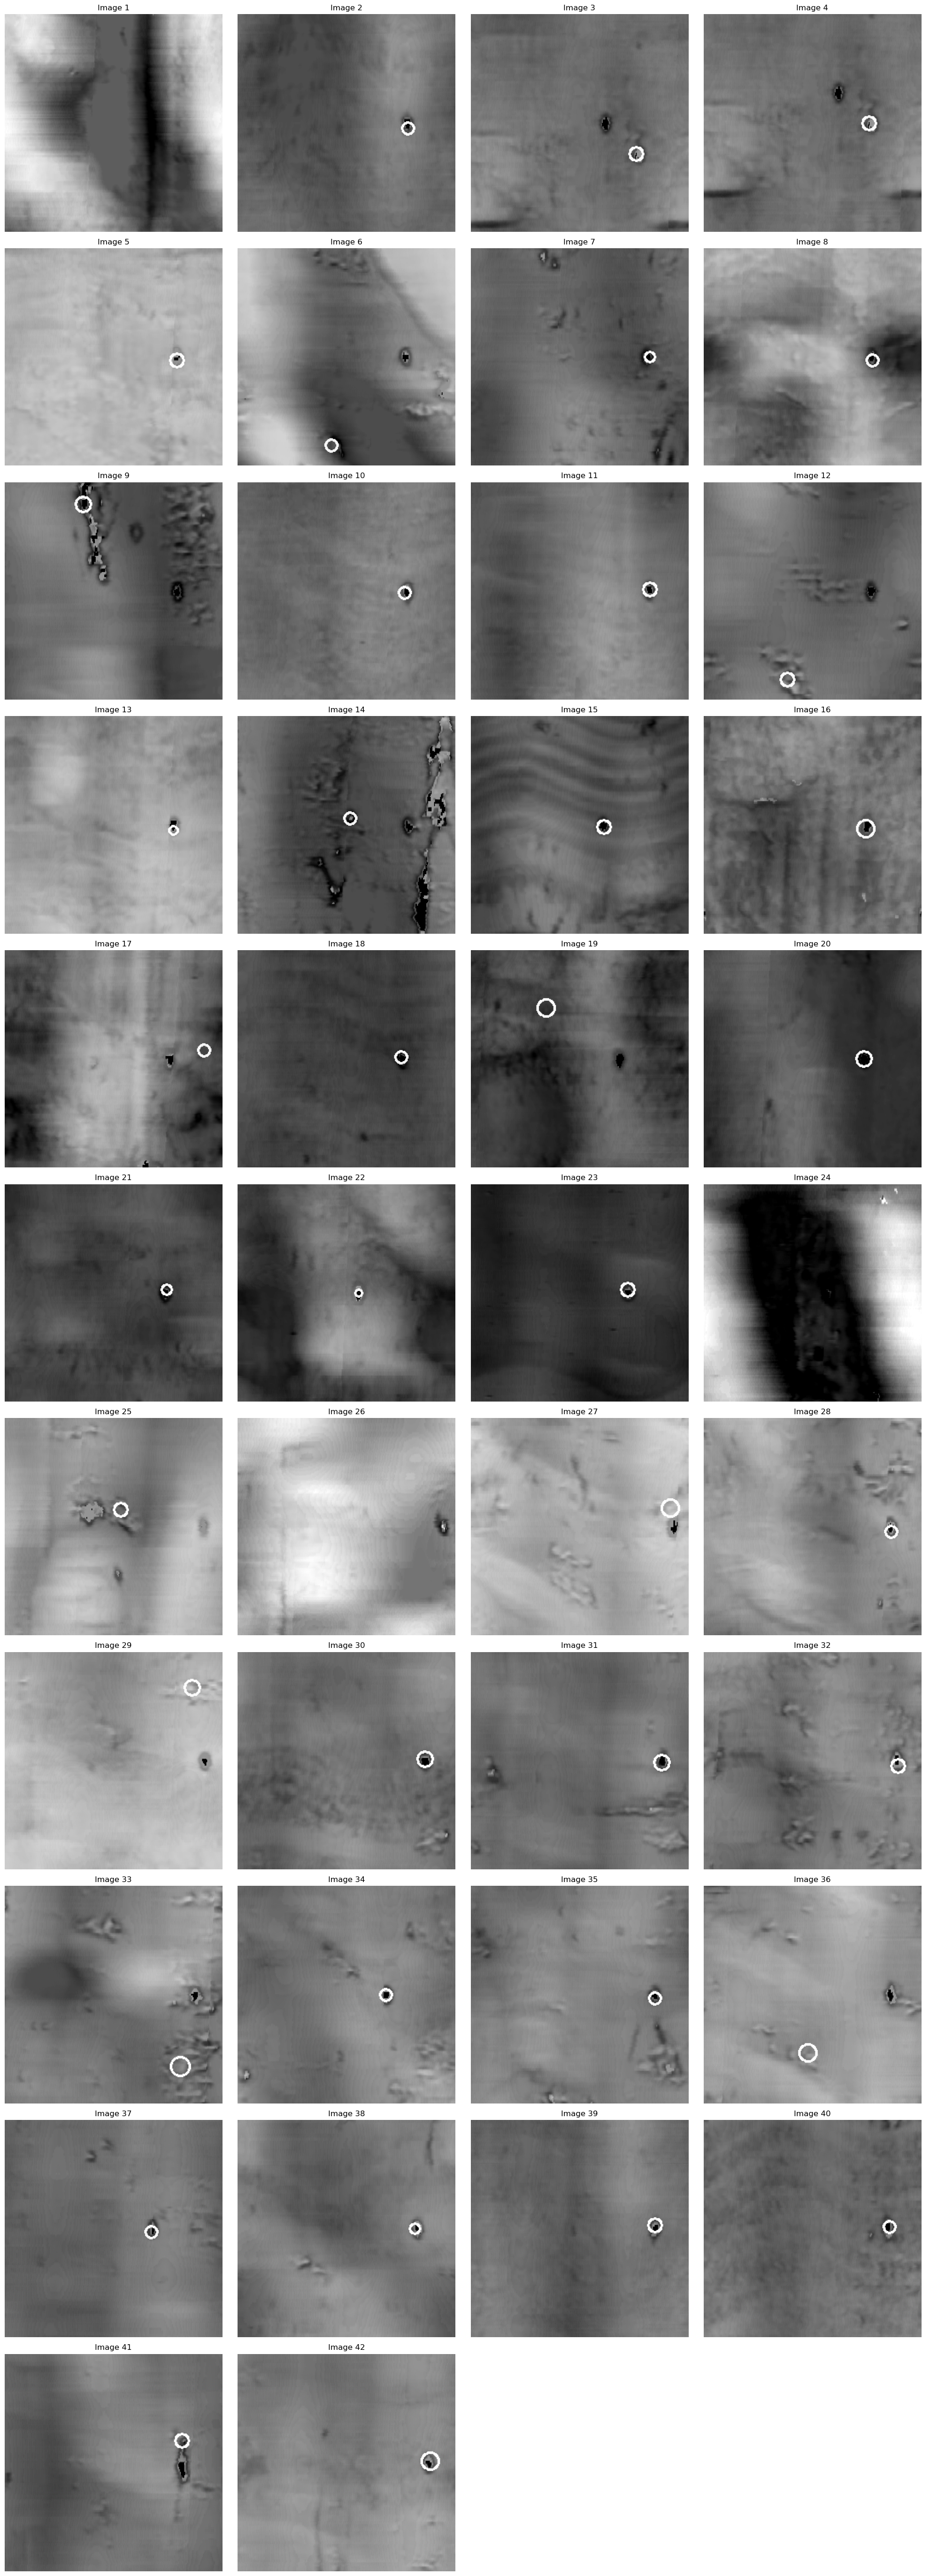

In [78]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assume you have a list of grayscale images named images_gray

# Function to detect circles in an image
def detect_circles(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1, minDist=140, param1=50, param2=13, minRadius=3, maxRadius=12)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            center = (circle[0], circle[1])
            radius = circle[2]
            cv2.circle(image, center, radius, (255,255,255), 2)

    return image  # Modified to return the image with circles

# Detect circles in all images
images_with_circles = [detect_circles(image_gray.copy()) for image_gray in images_gray]

# Plot images with four images in each row
num_rows = len(images_with_circles) // 4 + (len(images_with_circles) % 4 > 0)  # Calculate the number of rows

fig, axes = plt.subplots(num_rows, 4, figsize=(20, num_rows * 5))

for i, (image, ax) in enumerate(zip(images_with_circles, axes.flatten())):
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Image {i + 1}')
    ax.axis('off')

# Hide any empty subplots
for i in range(len(images_with_circles), num_rows * 4):
    axes.flatten()[i].axis('off')

plt.tight_layout()
plt.show()



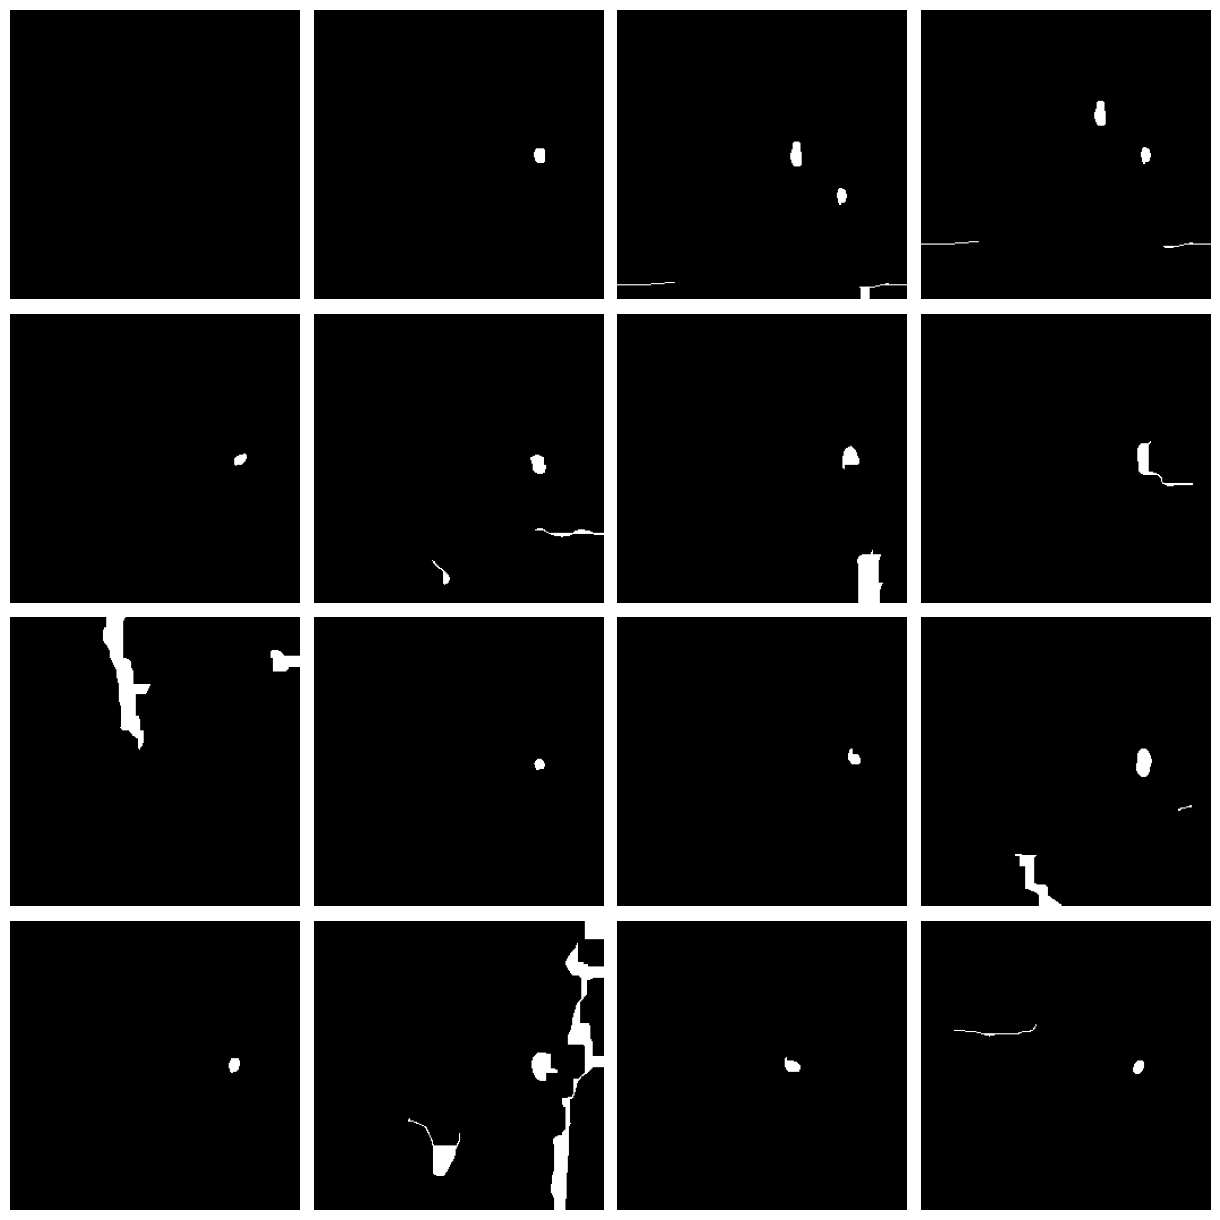

In [6]:
N2 = 19
kernel2 = np.ones((N2,N2),np.uint8)

closed_canny = [cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel2) for img in images_canny]
plot_images(closed_canny)

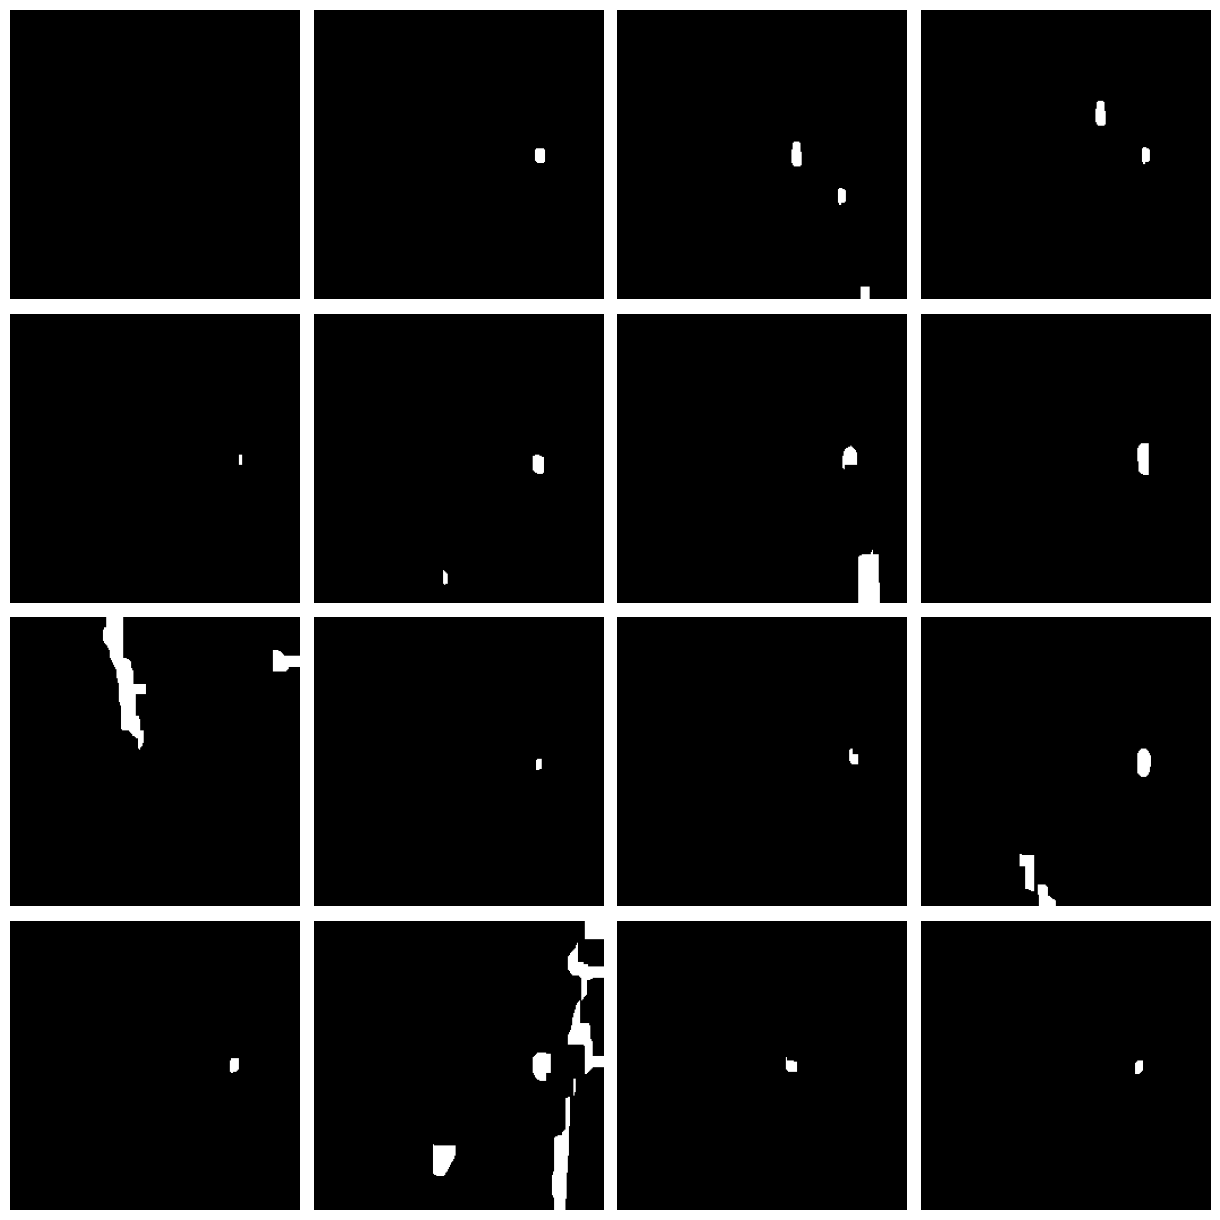

In [7]:
kernel2 = np.ones((9,1),np.uint8)

erode_canny = [cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel2) for img in closed_canny]
plot_images(erode_canny)

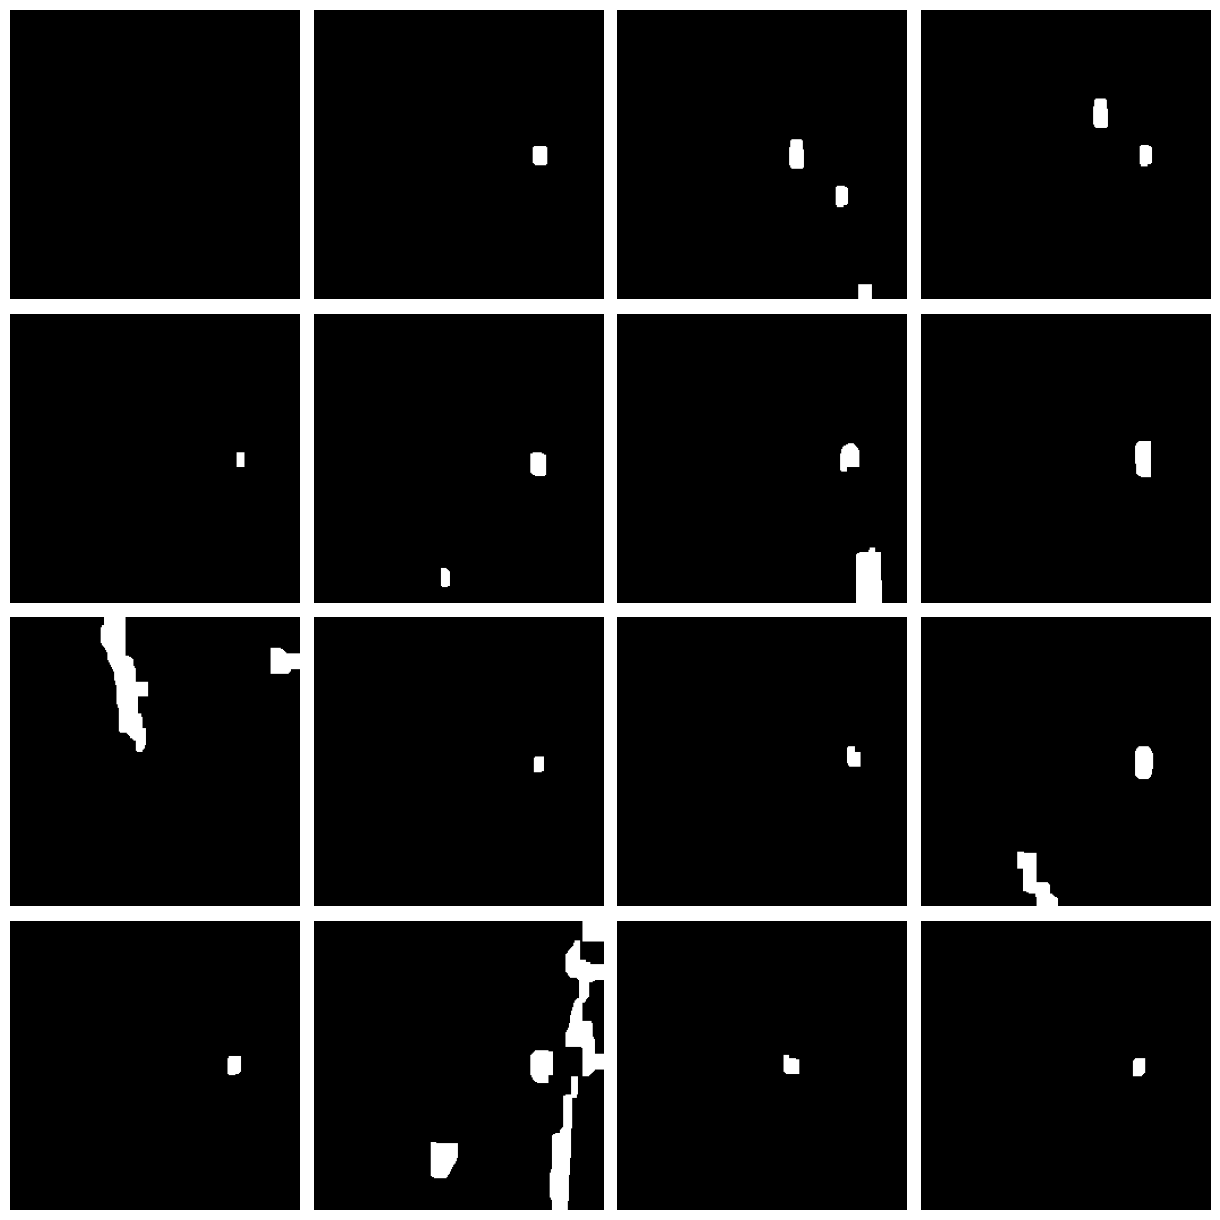

In [8]:
N2 = 5
kernel2 = np.ones((N2,N2),np.uint8)

closed_canny = [cv2.morphologyEx(img, cv2.MORPH_DILATE, kernel2) for img in erode_canny]
plot_images(closed_canny)

## Find blobs contours

### Scikit-image

In [9]:
# # Marching squares method to find 2D contours.
# from skimage.measure import find_contours

# ml_colors = ['red','yellow','lime','aqua','magenta','navy','hotpink']*100

In [10]:
# np.array(closed_canny).shape

In [11]:
# # Image index
# img_idx = 13

# # The function find_contours() returns a list with the detected contours
# contours_list = find_contours(closed_canny[img_idx])

# # Number of contour elements
# num_contours = len(contours_list)
# all_contours = np.concatenate(contours_list, axis=0)

# # Closed image plotting
# plt.imshow(closed_canny[img_idx],cmap='gray')

# # Plotting all 
# c_idx = 0
# for contour in contours_list:
#     for point in contour:
#         plt.scatter(point[1], point[0],s=0.5, color=ml_colors[c_idx])
#     c_idx += 1

# plt.axis('off')

In [12]:
# fig, axs = plt.subplots(5,5, figsize=(25,25))

# img_idx = 0
# for row in range(5):
#     for column in range(5):
#         axs[row,column].imshow(closed_canny[img_idx],cmap='gray')
        
#         contours_list = find_contours(closed_canny[img_idx])
#         c_idx = 0
#         for contour in contours_list:
#             for point in contour:
#                 axs[row,column].scatter(point[1], point[0],s=0.5, color=ml_colors[c_idx])
#             c_idx += 1
#         axs[row,column].axis('off')
#         img_idx += 1

### OpenCV

In [13]:
# OpenCV requires the closed images to be in a specific format: CV_8UC1

converted_images = []

for image in np.array(erode_canny):
    # Ensure that the image is in uint8 format (CV_8U)
    if image.max() == 1:
        image *= 255
    if image.dtype != np.uint8:
        image = image.astype(np.uint8)
    # Convert to CV_8UC1 format
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    converted_images.append(image)

In [14]:
contours = []
for img in converted_images:

    contours_list,_ = cv2.findContours(img, cv2.CHAIN_APPROX_SIMPLE, cv2.CHAIN_APPROX_NONE)
    contours.append(contours_list)

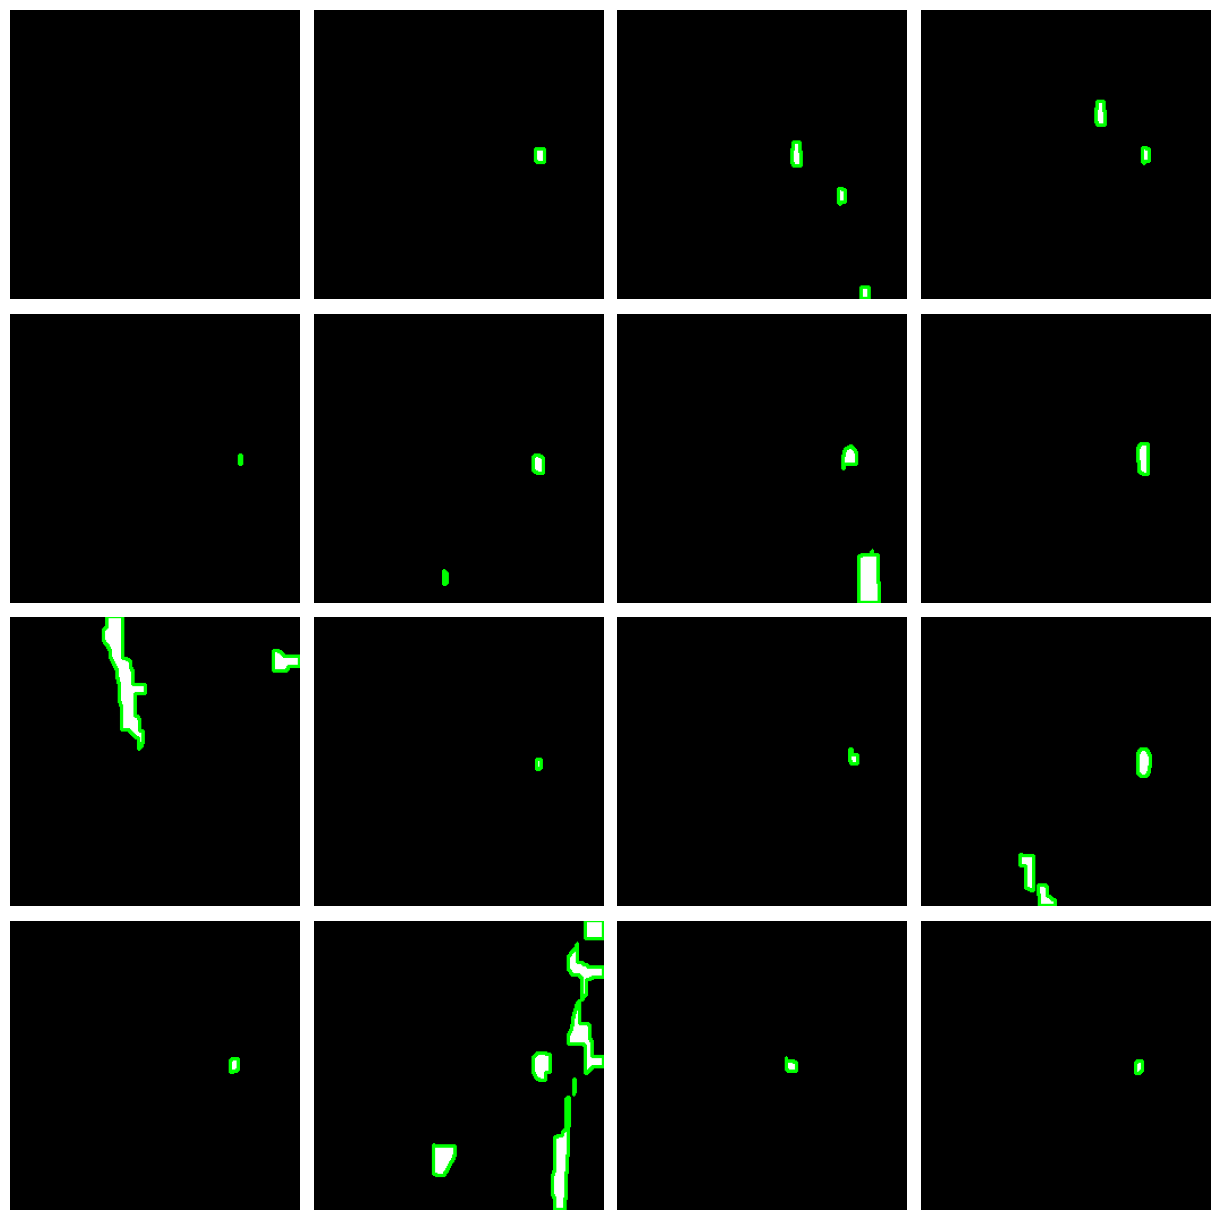

In [15]:
plot_images(converted_images, contours)

## Calculate blob's features

In [16]:

contour_areas = []
eccentricities = []
arclengths = []
filtered_contours = []
roundness = []

for contours_list in contours:

    new_contours_list = []
    for cntr in contours_list:
        
        area = cv2.contourArea(cntr)
        contour_areas.append(area)

        arclength = cv2.arcLength(cntr, True)
        arclengths.append(arclength)
        

        round_ratio =  4 * np.pi * area / ( arclength**2 )
        roundness.append(round_ratio)

        # ellipse = cv2.fitEllipse(cntr)
        # major_axis, minor_axis = ellipse[1]
        # if major_axis*minor_axis>0:
        #     eccentricity = minor_axis/major_axis
        #     eccentricities.append(eccentricity)

        if (round_ratio > 0.5) and (area > 20) and (area < 400):
            new_contours_list.append(cntr)
    
    filtered_contours.append(new_contours_list)
        

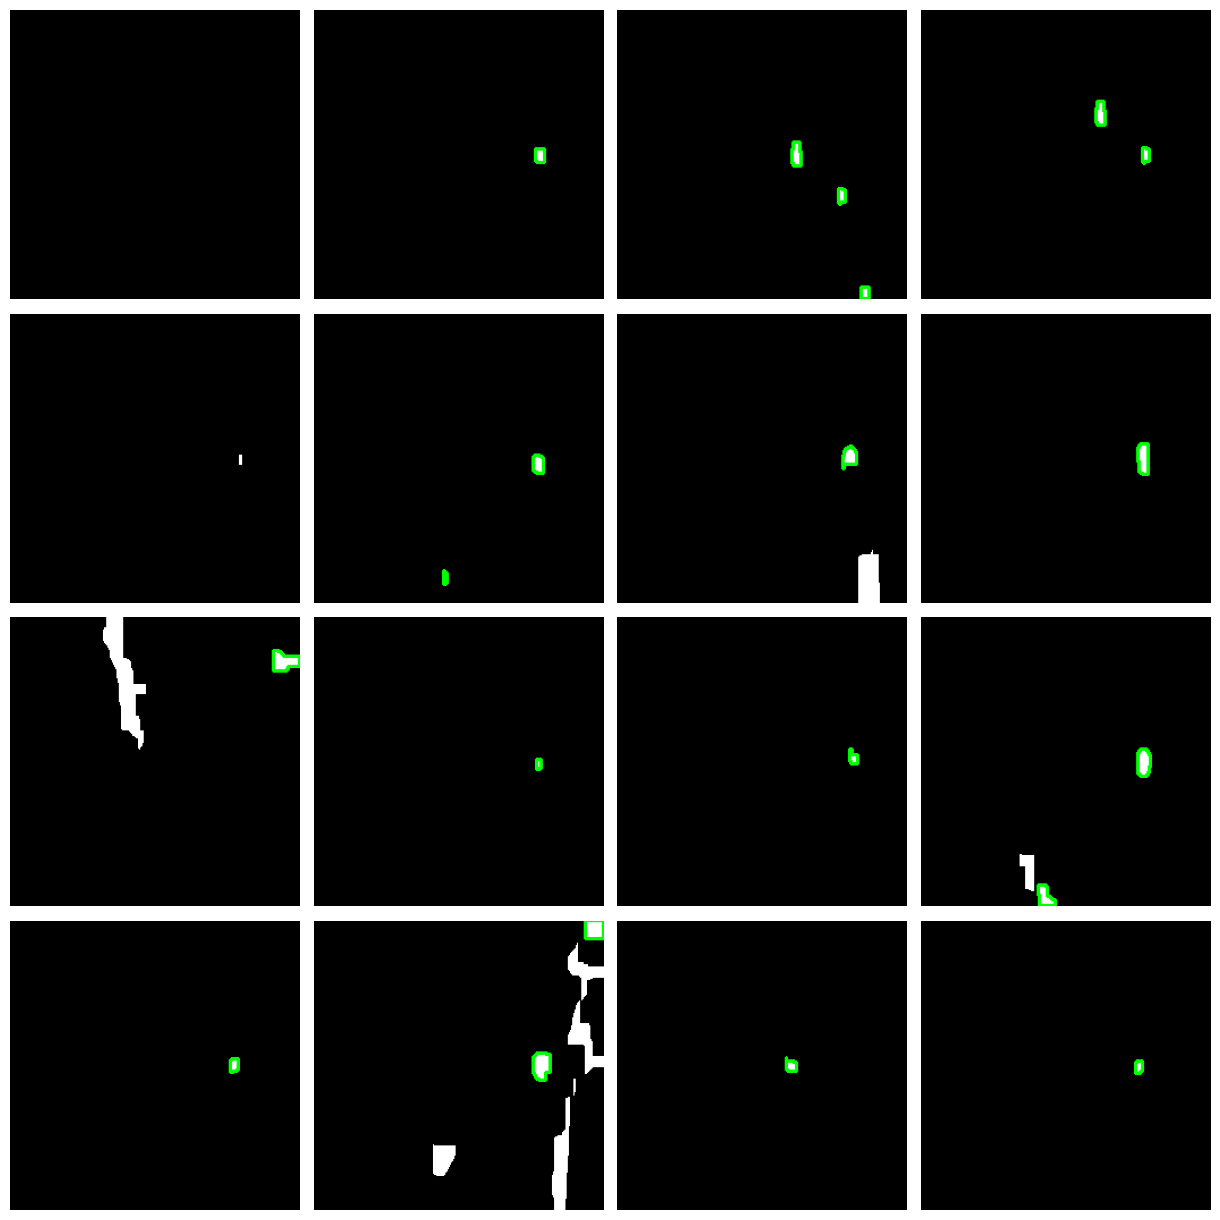

In [17]:
plot_images(converted_images, filtered_contours)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


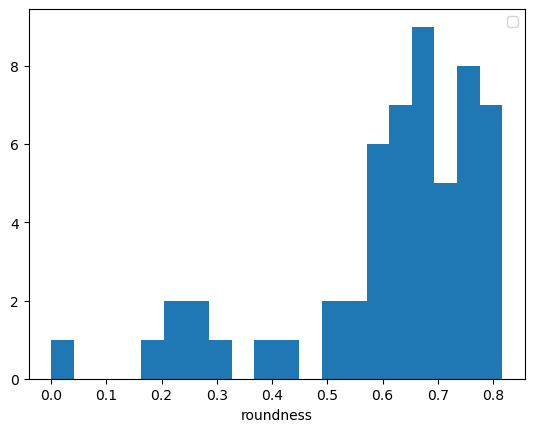

In [18]:
roundness.sort()
plt.hist(roundness[:-2], bins=20)
# plt.axvline(x=70, color='red', linestyle='--', label='Bottom area threshold')
# plt.axvline(x=230, color='red', linestyle='--', label='Upper area threshold')
plt.xlabel('roundness')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


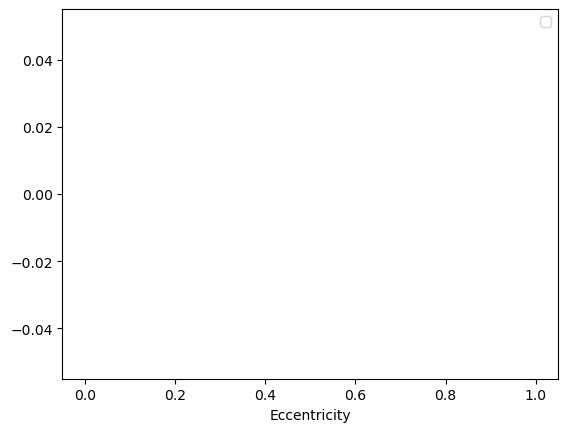

In [19]:
eccentricities.sort()
plt.hist(eccentricities[:-2], bins=20)
# plt.axvline(x=70, color='red', linestyle='--', label='Bottom area threshold')
# plt.axvline(x=230, color='red', linestyle='--', label='Upper area threshold')
plt.xlabel('Eccentricity')
plt.legend()
plt.show()

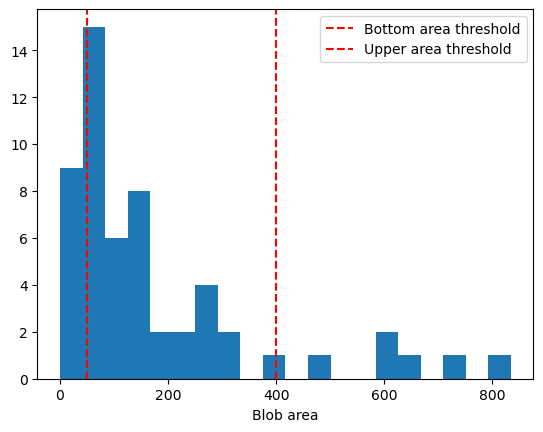

In [20]:
contour_areas.sort()
plt.hist(contour_areas[:-2], bins=20)
plt.axvline(x=50, color='red', linestyle='--', label='Bottom area threshold')
plt.axvline(x=400, color='red', linestyle='--', label='Upper area threshold')
plt.xlabel('Blob area')
plt.legend()
plt.show()